# ΣΥΣΤΗΜΑΤΑ ΛΗΨΗΣ ΑΠΟΦΕΑΣΕΩΝ
## Εκφωνηση 1  
### Ανδρεας Μαυροπουλος 217129


### Dataset Info
Tracking:
- Personnel
- Prisoner of War
- Armored Personnel Carrier
- Multiple Rocket Launcher
- Aircraft
- Anti-aircraft warfare
- Drone
- Field Artillery
- Fuel Tank
- Helicopter
- Military Auto
- Naval Ship
- Tank

Acronyms:
- POW - Prisoner of War,
- MRL - Multiple Rocket Launcher,
- BUK - Buk Missile System,
- APC - Armored Personnel Carrier,
- drone: UAV - Unmanned Aerial Vehicle, RPA - Remotely Piloted Vehicle. Dataset History

In [339]:
# GENERAL IMPORTS
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error,accuracy_score,f1_score
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge,RidgeCV,Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import LassoCV
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV


# IMPORTS FOR EDA
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
import seaborn as sns
import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
from scipy.interpolate import UnivariateSpline

# Task 1
import and fix dataset

In [340]:
equipment_loss = pd.read_csv('/content/drive/MyDrive/Kaggle/2022 Ukraine Russia War/russia_losses_equipment.csv')

personel_loss = pd.read_csv('/content/drive/MyDrive/Kaggle/2022 Ukraine Russia War/russia_losses_personnel.csv')

In [341]:
equipment_loss.head()

,date,day,aircraft,helicopter,tank,APC,field artillery,MRL,military auto,fuel tank,drone,naval ship,anti-aircraft warfare,special equipment,mobile SRBM system,vehicles and fuel tanks,cruise missiles,greatest losses direction
0,2022-02-25,2,10,7,80,516,49,4,100.0,60.0,0,2,0,NaN,NaN,NaN,NaN,NaN
1,2022-02-26,3,27,26,146,706,49,4,130.0,60.0,2,2,0,NaN,NaN,NaN,NaN,NaN
2,2022-02-27,4,27,26,150,706,50,4,130.0,60.0,2,2,0,NaN,NaN,NaN,NaN,NaN
3,2022-02-28,5,29,29,150,816,74,21,291.0,60.0,3,2,5,NaN,NaN,NaN,NaN,NaN
4,2022-03-01,6,29,29,198,846,77,24,305.0,60.0,3,2,7,NaN,NaN,NaN,NaN,NaN


In [342]:
personel_loss.head()

,date,day,personnel,personnel*,POW
0,2022-02-25,2,2800,about,0
1,2022-02-26,3,4300,about,0
2,2022-02-27,4,4500,about,0
3,2022-02-28,5,5300,about,0
4,2022-03-01,6,5710,about,200


Firstly fix the equipment loss dataframe

In [343]:
# CREATE A SINGLE COLUMN FOR AIRCRAFTS
equipment_loss['Aircrafts'] = equipment_loss['aircraft'] + equipment_loss['helicopter']

# CREATE A SINGLE COLUMN FOR TANKS
equipment_loss['Tanks'] = equipment_loss['tank'] + equipment_loss['fuel tank']

# DROP UNNECCESARY COLUMNS
equipment_loss = equipment_loss.drop(['date','aircraft', 'helicopter','tank','fuel tank','vehicles and fuel tanks','greatest losses direction','mobile SRBM system'], axis = 1)

# FILL MISSING VALUES
equipment_loss = equipment_loss.replace('nan', np.nan).fillna(0)

# equipment_loss.dtypes

# Turn float values to integer
equipment_loss[['military auto', 'special equipment','cruise missiles','Tanks']] = equipment_loss[['military auto', 'special equipment','cruise missiles','Tanks']].astype(int)

Now lets fix the personel dataframe

In [344]:
# DROP UNNECCESARY COLUMNS
personel_loss = personel_loss.drop(['date','personnel*'],axis=1)

# ADD DEATHS PER DAY COLUMN
deaths_per_day=[]
for index,item in enumerate(personel_loss['personnel']):
  if index==0:
    deaths_per_day.append(item)
  else:
    deaths_per_day.append(item-personel_loss['personnel'][index-1])

personel_loss['deaths per day'] = deaths_per_day


# Task 2
EDA

Firstly Plot out the personel loss dataframe


In [345]:
# View total deaths in relation to days
fig = go.Figure()

fig.add_trace(go.Scatter(x=personel_loss['day'], y=personel_loss['personnel'],
                    mode='lines+markers+text',
                    name='Russian troops',
                    line_shape='spline',
                    textposition="bottom center"))

fig.update_layout(title="Total Deaths",
                  xaxis_title="Days",
                  yaxis_title="Deaths")
fig.show()

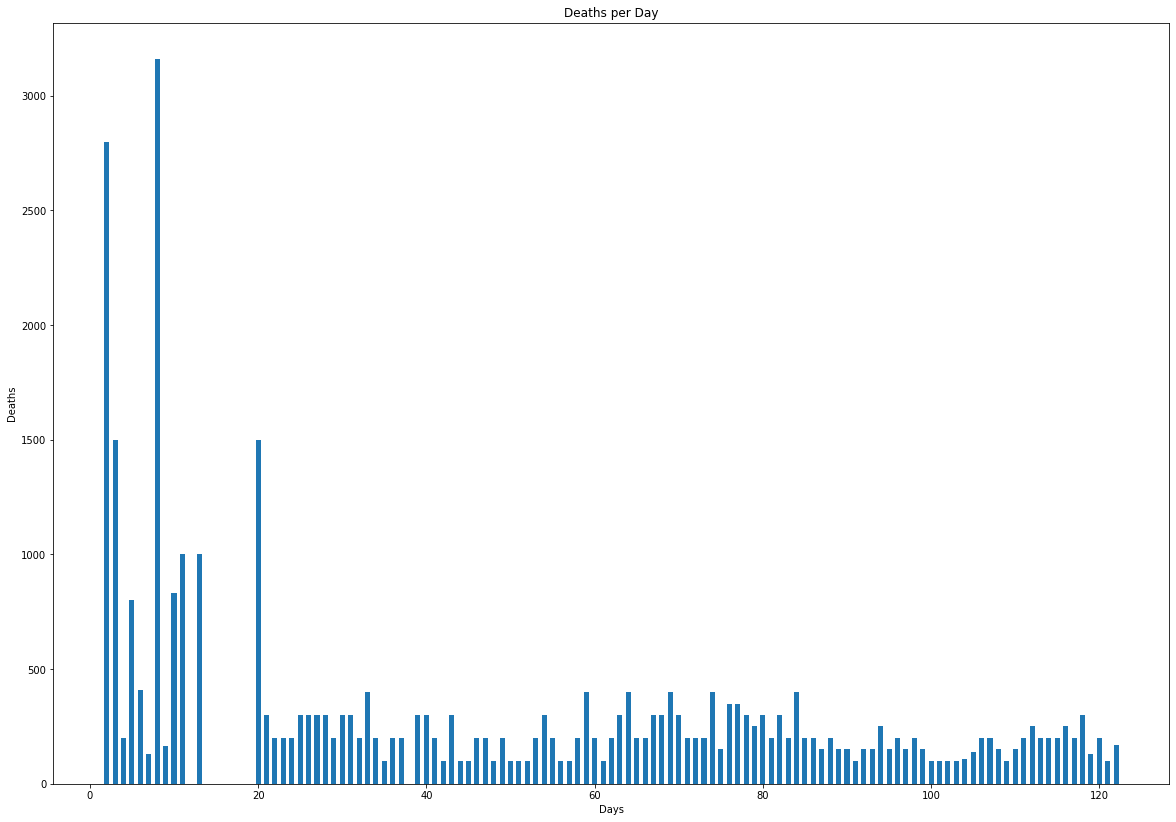

In [346]:
# Plot out the new daily deaths
fig = plt.figure(figsize = (20, 14))
plt.bar(personel_loss['day'],personel_loss['deaths per day'],width=0.6,)

 
plt.xlabel("Days")
plt.ylabel("Deaths")
plt.title("Deaths per Day")
plt.show()

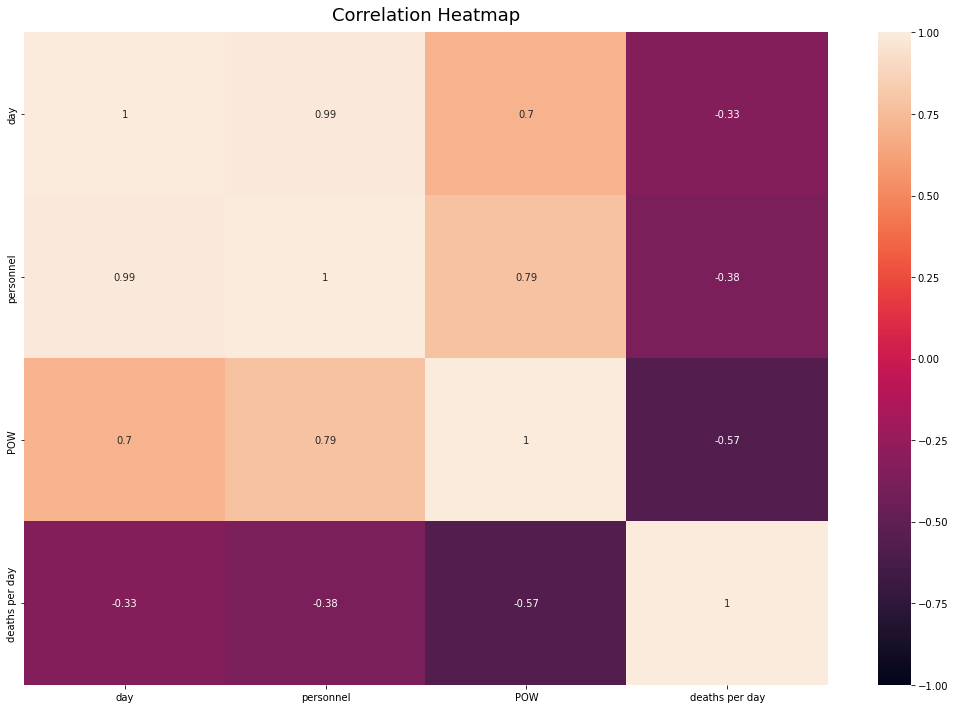

In [347]:
# Plot out a correleation heatmap

fig = plt.figure(figsize = (18, 12))
heatmap = sns.heatmap(personel_loss.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);
plt.show()

In [348]:
# View Prisoners in relation to deaths
total_deaths = personel_loss['personnel'][len(personel_loss)-1]
prisoners = personel_loss['POW'][len(personel_loss)-1]

fig = go.Figure(data=[go.Pie(labels=['deaths','Prisoners'], values=[total_deaths,prisoners], textinfo='label',
                             insidetextorientation='radial'
)])

fig.show()

Time to plot out the Equipment loss dataframe

In [349]:
def add_fig_trace(x,y,label):
  return fig.add_trace(go.Scatter(x=x, y=y,
                    mode='lines+markers+text',
                    name=label,
                    line_shape='spline',
                    textposition="bottom center"))

In [350]:
# Plot out the important russina losses per day
fig = go.Figure()

for index , item in enumerate(equipment_loss):
  if index != 0:
    add_fig_trace(equipment_loss['day'],equipment_loss[item],item)

fig.update_layout(title="Russian losses",
                  xaxis_title="Day",
                  yaxis_title="Losses",)

fig.show()

In [351]:
# Lets try to plot them out separately

# Lets plot out only the aerial 


fig = go.Figure()


add_fig_trace(equipment_loss['day'],equipment_loss['Aircrafts'],'Aircrafts')

add_fig_trace(equipment_loss['day'],equipment_loss['drone'],'Drones')


fig.update_layout(title="Russian Aerian losses",
                  xaxis_title="Day",
                  yaxis_title="Losses",)

fig.show()

In [352]:
# Lets plot out only the Ammunition 

fig = go.Figure()


add_fig_trace(equipment_loss['day'],equipment_loss['anti-aircraft warfare'],'anti-aircraft warfare')

add_fig_trace(equipment_loss['day'],equipment_loss['special equipment'],'special equipment')

add_fig_trace(equipment_loss['day'],equipment_loss['cruise missiles'],'cruise missiles')


fig.update_layout(title="Russian Ammunition losses",
                  xaxis_title="Day",
                  yaxis_title="Losses",)

fig.show()

In [353]:
# View Aerian Relation
aircrafts = equipment_loss['Aircrafts'][len(equipment_loss)-1]
drones = equipment_loss['drone'][len(equipment_loss)-1]


fig = go.Figure(data=[go.Pie(labels=['Aircrafts','Drones'], values=[aircrafts,drones], textinfo='label',
                             insidetextorientation='radial',
)])

fig.show()

## Τα 3 features
Αρχικα απο το personel loss dataframe θα παρω το `personel`. 
Στην συνεχεια απο το equipment loss dataframe θα παρω τα `APC` και `Field Artillery`. Η επιλογες μου εγιναν με βαση το correleation heatmap οπου προσεξα οτι αυτες οι τιμες εχουν την καλυτερη σχεση μεταξυ τους και των ημερων.

# Task 3

Lets setup the personel loss train test datasets

In [354]:
# Plots out the predictions in a scatter plot
def plot_predictions(train_data,
                     train_labels,
                     test_data,
                     test_labels,
                     prediction_data,
                     predictions,
                     isPred):
  """
  Plots training data,test data
  and compares predictions to ground truth labels
  """
  plt.figure(figsize=(18,10))
  # Plot the training data in blue
  plt.scatter(train_data,train_labels,c="b",label="Training data")
  # Plot the testing data in green
  plt.scatter(test_data,test_labels,c="g",label="Testing data")
  # Plot the models predictions in red
  if isPred:
    plt.scatter(prediction_data,predictions,c="r",label="Predictions")
  # Show legend
  plt.legend()
  plt.show();

In [396]:
# Makes a train test split and normalizes data
def make_data(X,y,normal):

  X_train, X_test, y_train, y_test = train_test_split(
      X, 
      y, 
      test_size=0.2)
  
  # Setup unseen values
  unseen_values = pd.DataFrame([123,124,125,126,127,128,129,130])
  # size_of_X = int(len(X)*0.8)
  # size_of_y = int(len(y)*0.8)

  # X_train = X[:size_of_X]
  # X_test  = X[size_of_X:]
  # y_train = y[:size_of_y]
  # y_test  = y[size_of_X:]



  X_train = pd.DataFrame(X_train)
  X_test = pd.DataFrame(X_test)
  y_train = pd.DataFrame(y_train)
  y_test = pd.DataFrame(y_test)

  # Normalize data
  if normal:
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    unseen_values = scaler.transform(unseen_values)





  return X_train, X_test, y_train, y_test,unseen_values

<Figure size 720x432 with 0 Axes>

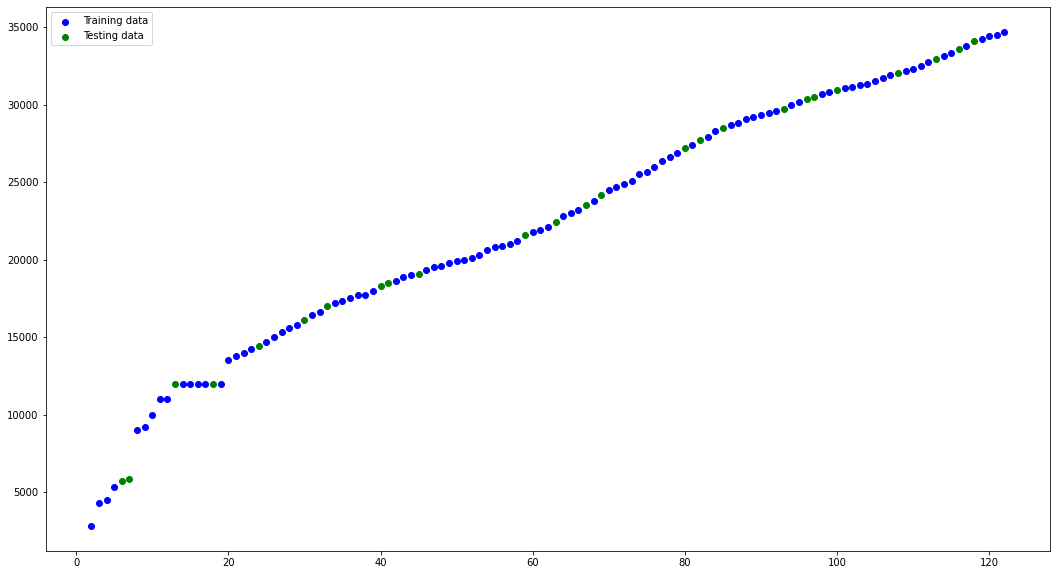

In [398]:
plt.figure(figsize=(10,6))

 
X_train, X_test, y_train, y_test ,unseen_values = make_data(personel_loss['day'],personel_loss['personnel'],normal=False)


plot_predictions(X_train,
                 y_train,
                 X_test,
                 y_test,
                 None,
                 None,
                 False)

## Personnel Model 1 Linear Regression


In [399]:
reg = LinearRegression().fit(X_train,y_train)
y_pred_reg  = reg.predict(X_test)

print("Accuracy : " , accuracy_score(y_test, np.argmax(y_pred_reg, axis=1)) )
print("F1",f1_score(y_test,np.argmax(y_pred_reg, axis=1), average='micro'))
print("R^2 : ", r2_score(y_test, y_pred_reg))
print("MAE :", mean_absolute_error(y_test,y_pred_reg))
print("RMSE:",np.sqrt(mean_squared_error(y_test, y_pred_reg)))

Accuracy :  0.0
F1 0.0
R^2 :  0.9757083651971356
MAE : 900.8691367171886
RMSE: 1307.0645184416885


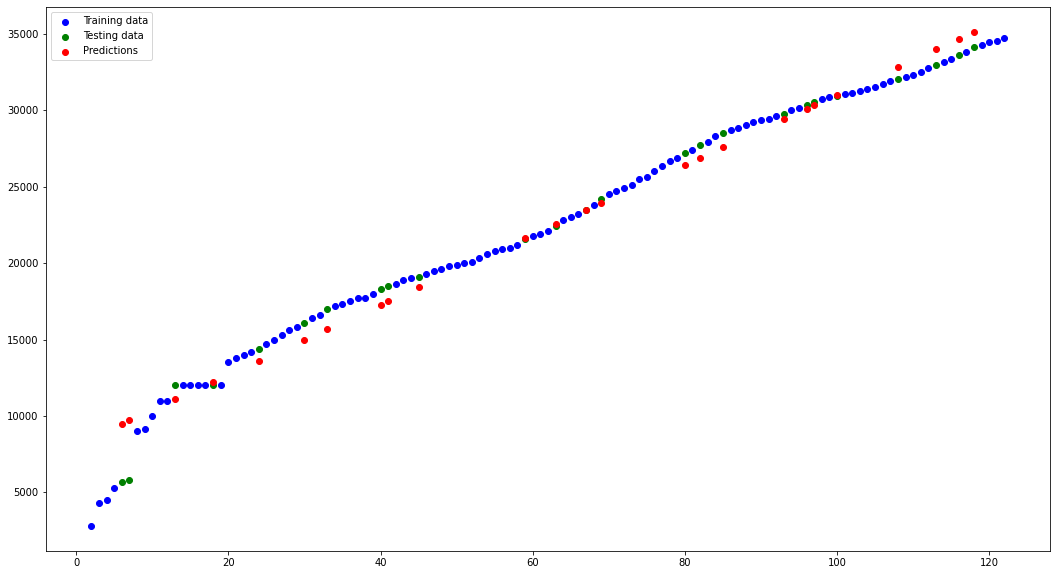

In [400]:
plot_predictions(X_train,
                 y_train,
                 X_test,
                 y_test,
                 X_test,
                 y_pred_reg,
                 True)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but LinearRegression was fitted with feature names



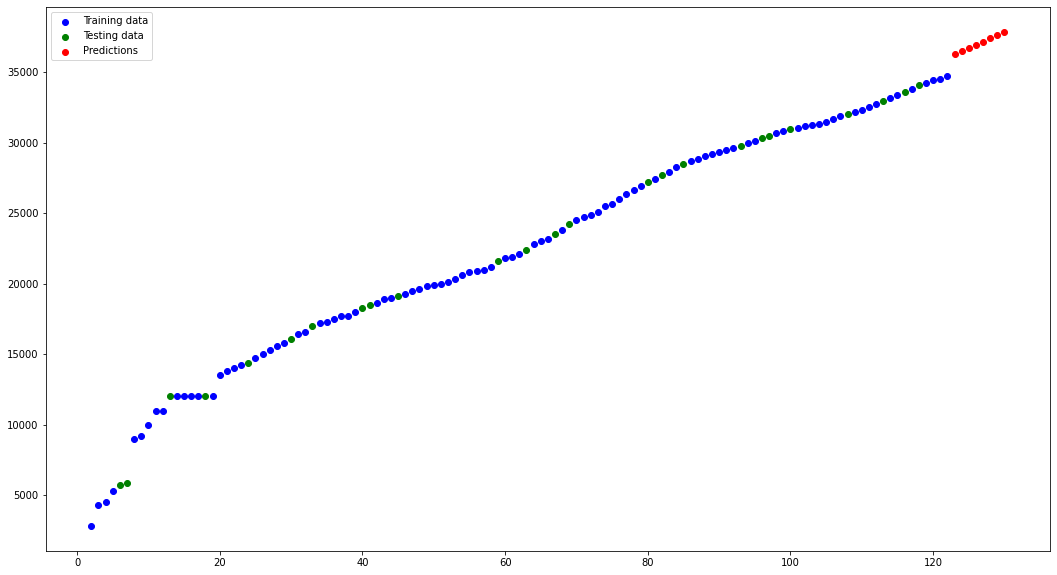

In [401]:
y_pred = reg.predict(unseen_values)

plot_predictions(X_train,
                 y_train,
                 X_test,
                 y_test,
                 unseen_values,
                 y_pred,
                 True)

## Personnel Model 2 Lasso Regression with crossvalidation

In [405]:
lasso = LassoCV().fit(X_train, y_train.values.reshape(len(y_train),))

In [406]:
y_pred_lasso = lasso.predict(X_test)

int_pred = []
for item in y_pred_lasso:
  int_pred.append(int(item))


print("Accuracy : " , accuracy_score(y_test, int_pred) )
print("F1",f1_score(y_test,int_pred, average='micro'))
print("R^2 : ", r2_score(y_test, y_pred_lasso))
print("MAE :", mean_absolute_error(y_test,y_pred_lasso))
print("RMSE:",np.sqrt(mean_squared_error(y_test, y_pred_lasso)))

Accuracy :  0.0
F1 0.0
R^2 :  0.9756433228652036
MAE : 898.4985709989395
RMSE: 1308.8132210943177


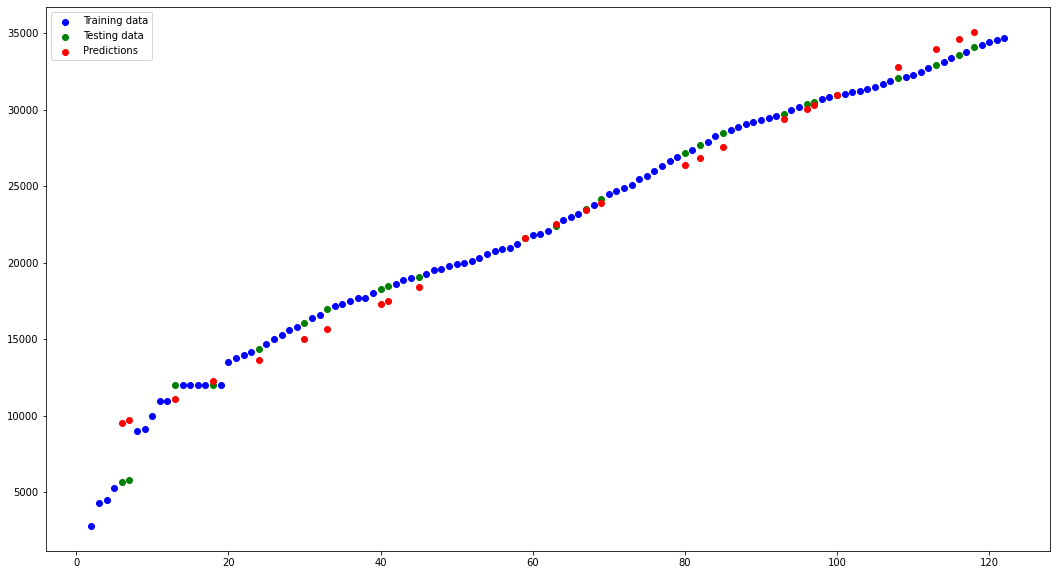

In [408]:
plot_predictions(X_train,
                 y_train,
                 X_test,
                 y_test,
                 X_test,
                 y_pred_lasso,
                 True)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but LassoCV was fitted with feature names



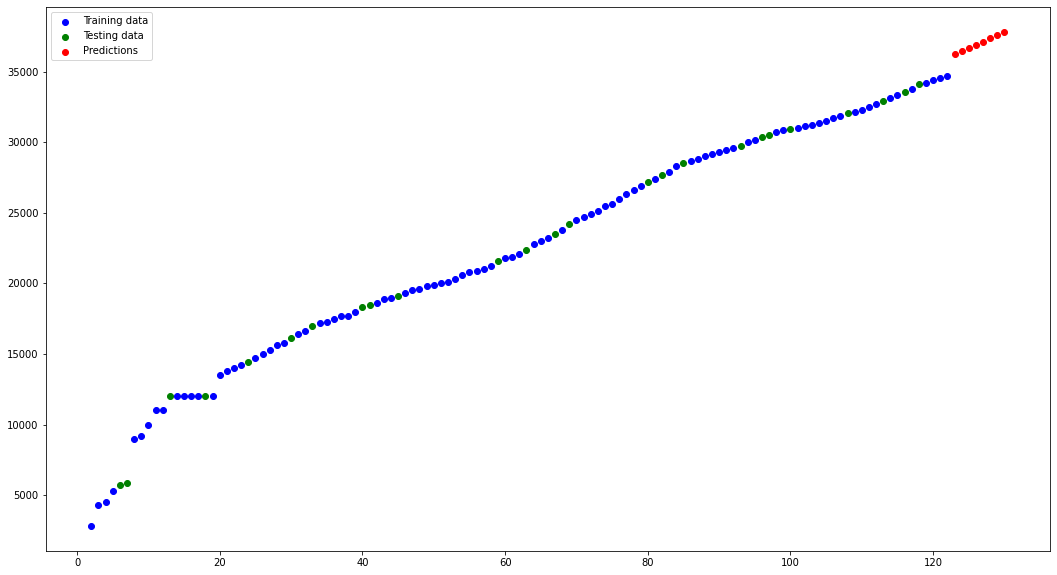

In [409]:
y_pred = lasso.predict(unseen_values)

plot_predictions(X_train,
                 y_train,
                 X_test,
                 y_test,
                 unseen_values,
                 y_pred,
                 True)

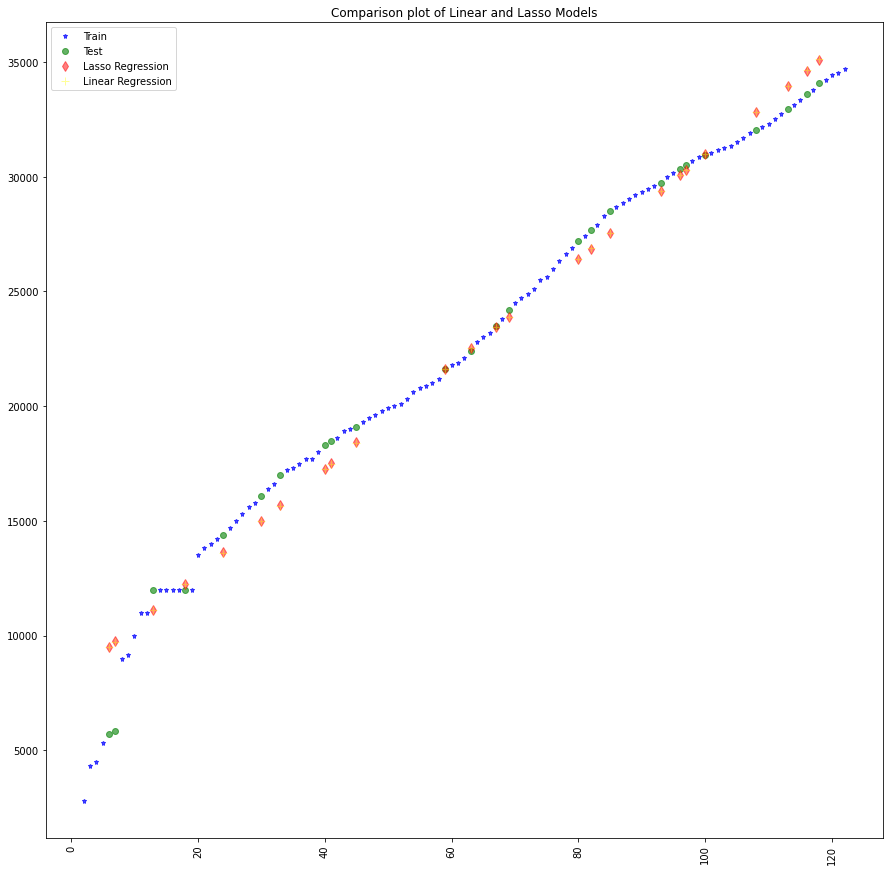

In [411]:
#plot size
plt.figure(figsize = (15, 15))

#add plot for training
plt.plot(X_train,y_train,alpha=0.7,linestyle='none',marker='*',markersize=5,color='blue',label=r'Train',zorder=7)

#addd plot for testing
plt.plot(X_test,y_test,alpha=0.6,linestyle='none',marker='o',markersize=6,color='green',label=r'Test')

#add plot for lasso model
plt.plot(X_test,y_pred_lasso,alpha=0.5,linestyle='none',marker='d',markersize=7,color='red',label='Lasso Regression')

#add plot for linear model
plt.plot(X_test,y_pred_reg,alpha=0.4,linestyle='none',marker='+',markersize=8,color='yellow',label='Linear Regression')

#rotate axis
plt.xticks(rotation = 90)
plt.legend()
plt.title("Comparison plot of Linear and Lasso Models")
plt.show()

## Time to move on to equipment loss 
Strating with APC

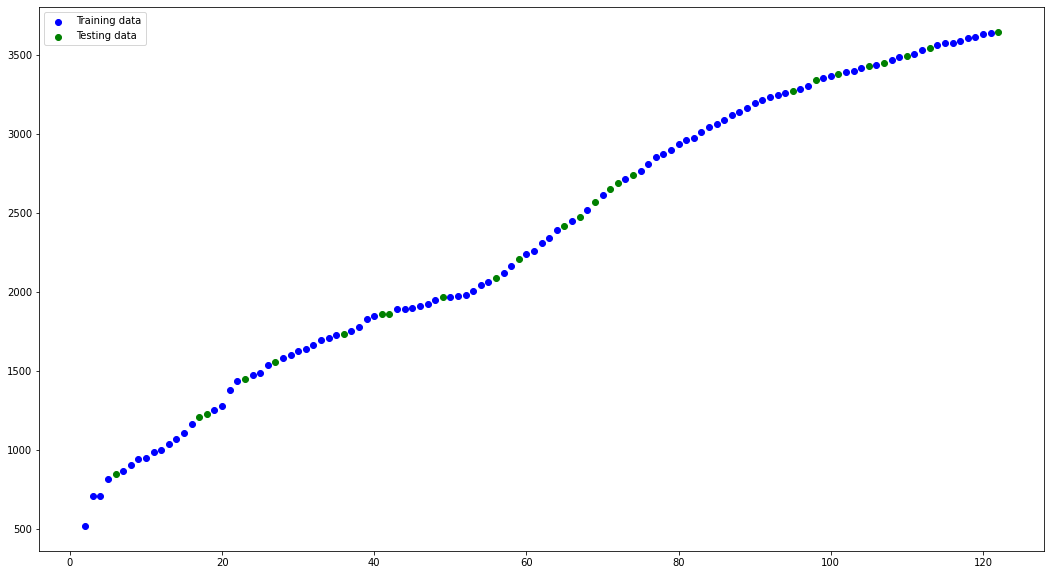

In [412]:
X_train, X_test, y_train, y_test ,unseen_values = make_data(equipment_loss['day'],equipment_loss['APC'],normal=False)

plot_predictions(X_train,
                 y_train,
                 X_test,
                 y_test,
                 None,
                 None,
                 False)

## APC Model 1 Linear Regression

In [413]:
apc_reg = LinearRegression().fit(X_train,y_train)
y_pred_reg  = apc_reg.predict(X_test)
int_pred_reg = []

for item in y_pred_reg:
  int_pred_reg.append(int(item))

In [415]:
print("Accuracy : " , accuracy_score(y_test, int_pred_reg) )
print("F1",f1_score(y_test,int_pred_reg, average='micro'))
print("R^2 : ", r2_score(y_test, int_pred_reg))
print("MAE :", mean_absolute_error(y_test,int_pred_reg))
print("RMSE:",np.sqrt(mean_squared_error(y_test, int_pred_reg)))

Accuracy :  0.0
F1 0.0
R^2 :  0.9906234450673385
MAE : 64.36
RMSE: 80.4579393223565


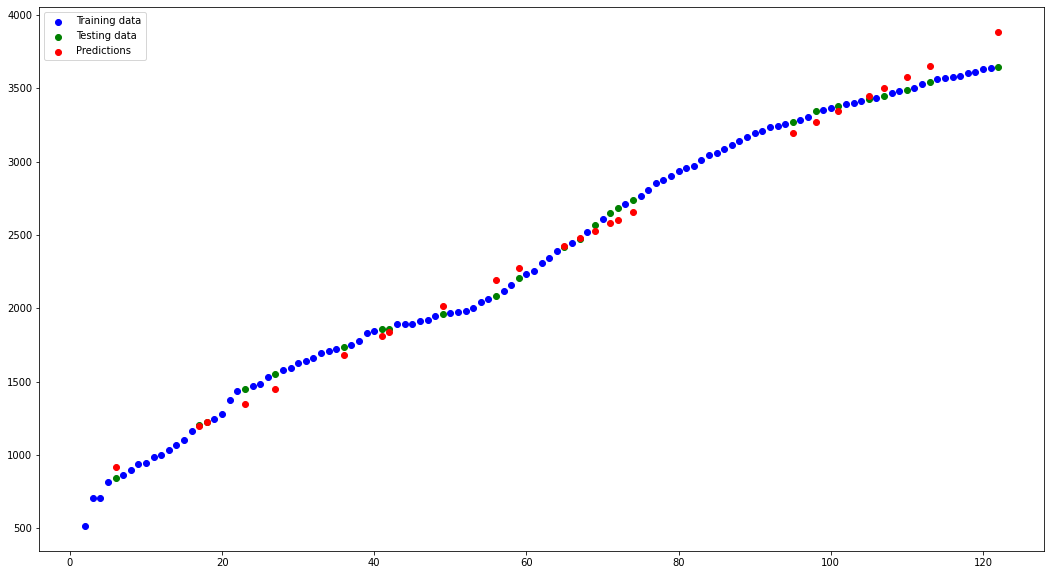

In [416]:
plot_predictions(X_train,
                 y_train,
                 X_test,
                 y_test,
                 X_test,
                 y_pred_reg,
                 True)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but LinearRegression was fitted with feature names



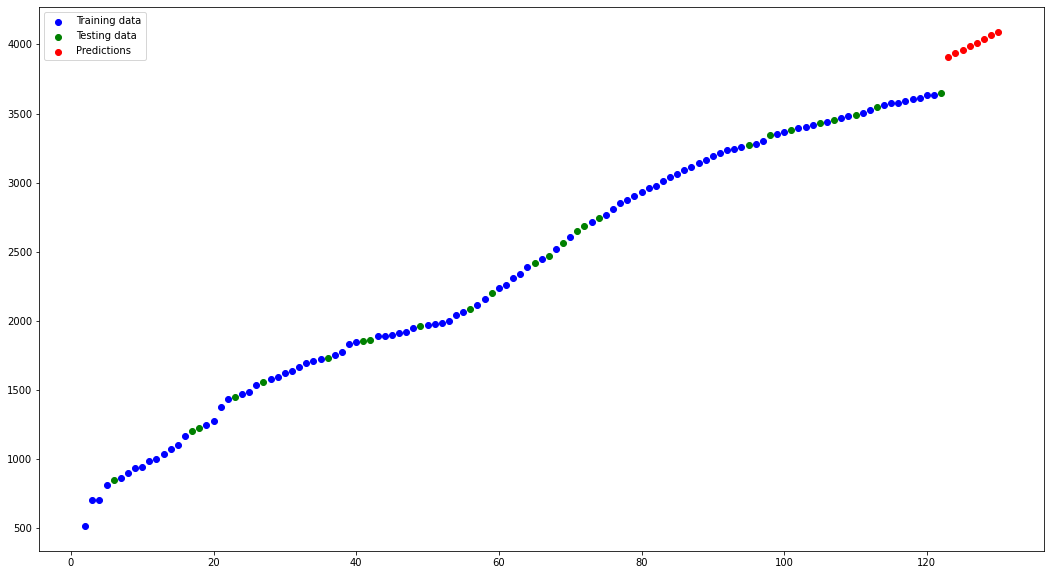

In [417]:
y_pred = apc_reg.predict(unseen_values)

plot_predictions(X_train,
                 y_train,
                 X_test,
                 y_test,
                 unseen_values,
                 y_pred,
                 True)

## APC MODEL 2 lasso regression

In [418]:
apc_lasso = LassoCV(alphas = [0.0001, 0.001,0.01, 0.1, 1, 10]).fit(X_train, y_train)

y_pred_lasso = apc_lasso.predict(X_test)

int_pred_lasso = []
for item in y_pred_lasso:
  int_pred_lasso.append(int(item))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:1571: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



In [419]:
print("Accuracy : " , accuracy_score(y_test, int_pred_lasso))
print("F1",f1_score(y_test,int_pred_lasso, average='micro'))
print("R^2 : ", r2_score(y_test, int_pred_lasso))
print("MAE :", mean_absolute_error(y_test,int_pred_lasso))
print("RMSE:",np.sqrt(mean_squared_error(y_test, int_pred_lasso)))

Accuracy :  0.0
F1 0.0
R^2 :  0.9906579183347923
MAE : 64.24
RMSE: 80.30989976335421


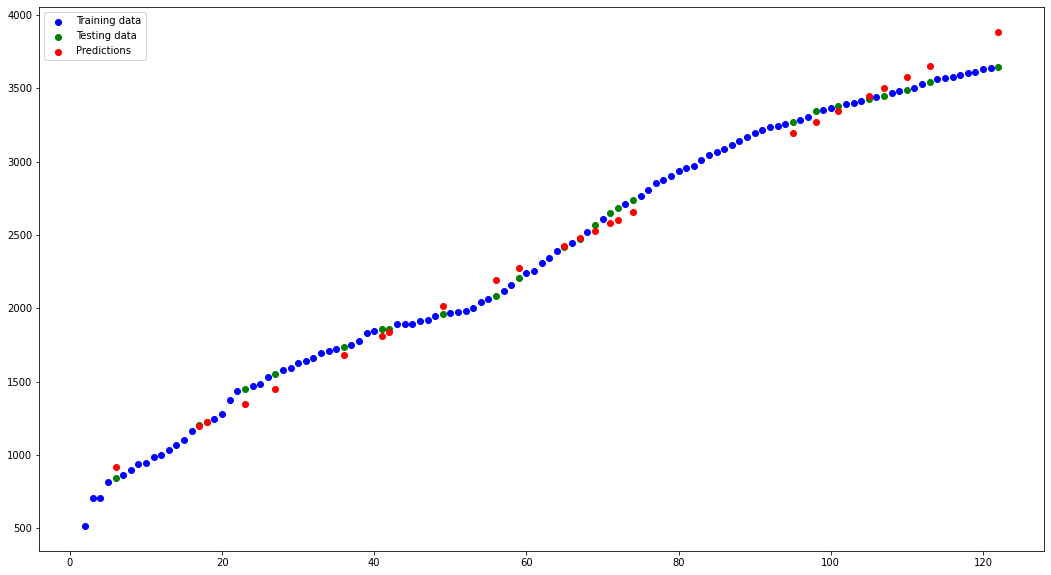

In [420]:
plot_predictions(X_train,
                 y_train,
                 X_test,
                 y_test,
                 X_test,
                 y_pred_lasso,
                 True)

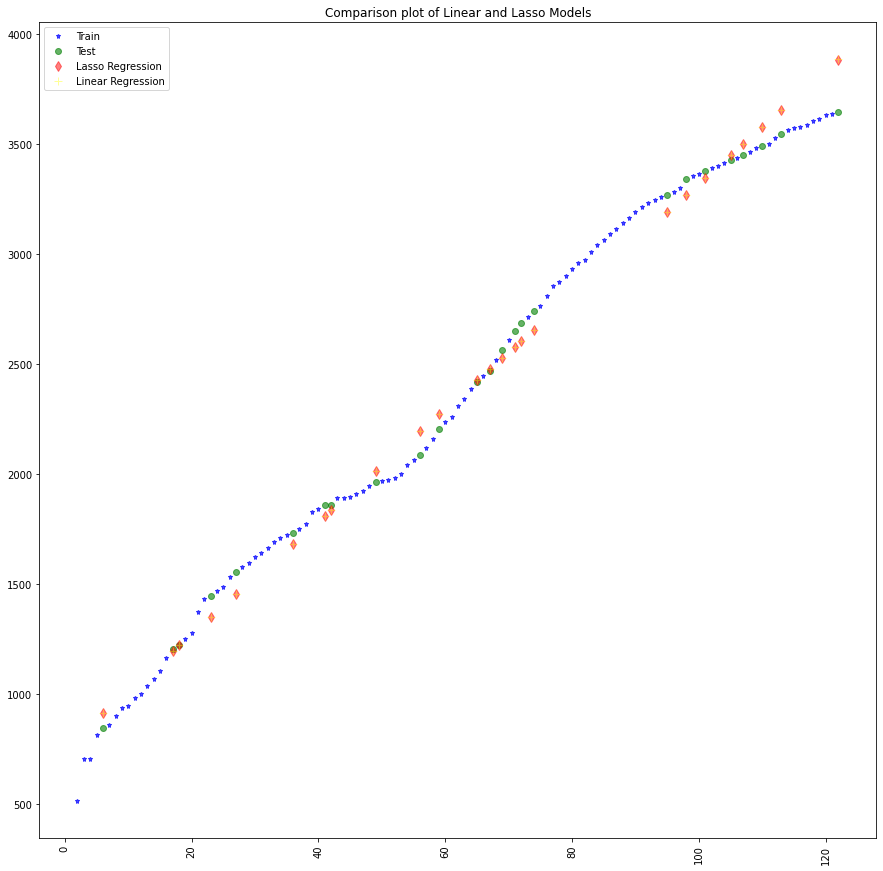

In [421]:
#plot size
plt.figure(figsize = (15, 15))

#add plot for training
plt.plot(X_train,y_train,alpha=0.7,linestyle='none',marker='*',markersize=5,color='blue',label=r'Train',zorder=7)

#addd plot for testing
plt.plot(X_test,y_test,alpha=0.6,linestyle='none',marker='o',markersize=6,color='green',label=r'Test')

#add plot for lasso model
plt.plot(X_test,y_pred_lasso,alpha=0.5,linestyle='none',marker='d',markersize=7,color='red',label='Lasso Regression')

#add plot for linear model
plt.plot(X_test,y_pred_reg,alpha=0.4,linestyle='none',marker='+',markersize=8,color='yellow',label='Linear Regression')

#rotate axis
plt.xticks(rotation = 90)
plt.legend()
plt.title("Comparison plot of Linear and Lasso Models")
plt.show()

## Field Aritllery Model 1 CatBoost


In [422]:
!pip install catboost
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [423]:
from catboost import CatBoostRegressor

# Get artilery field data
X_train, X_test, y_train, y_test ,unseen_values = make_data(equipment_loss['day'],equipment_loss['field artillery'],normal=True)


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names



In [424]:
cat_boost_model = CatBoostRegressor()
cat_boost_model.fit(X_train,y_train)

Learning rate set to 0.028273
0:	learn: 205.9469849	total: 259us	remaining: 260ms
1:	learn: 201.4613277	total: 845us	remaining: 422ms
2:	learn: 197.0692731	total: 1.38ms	remaining: 459ms
3:	learn: 192.5520770	total: 1.89ms	remaining: 470ms
4:	learn: 188.2833675	total: 2.28ms	remaining: 454ms
5:	learn: 184.0570899	total: 2.78ms	remaining: 460ms
6:	learn: 180.0514549	total: 3.3ms	remaining: 469ms
7:	learn: 175.8475485	total: 3.8ms	remaining: 471ms
8:	learn: 172.1054561	total: 4.3ms	remaining: 474ms
9:	learn: 168.3135962	total: 4.82ms	remaining: 477ms
10:	learn: 164.6599691	total: 5.21ms	remaining: 469ms
11:	learn: 161.0055131	total: 5.75ms	remaining: 474ms
12:	learn: 157.6902641	total: 6.25ms	remaining: 474ms
13:	learn: 154.0779641	total: 6.75ms	remaining: 475ms
14:	learn: 150.5866446	total: 7.27ms	remaining: 477ms
15:	learn: 147.1778735	total: 7.76ms	remaining: 478ms
16:	learn: 144.0452119	total: 8.28ms	remaining: 479ms
17:	learn: 140.7942647	total: 8.77ms	remaining: 478ms
18:	learn: 13

In [425]:
y_pred_cat = cat_boost_model.predict(X_test)

int_cat_pred = []

for item in y_pred_cat:
  int_cat_pred.append(int(item))

# Get all values in order to plot them out later
cat_acc = accuracy_score(y_test, int_cat_pred)
cat_f1 = f1_score(y_test,int_cat_pred, average='micro')
cat_r2 = r2_score(y_test, int_cat_pred)
cat_mae = mean_absolute_error(y_test,int_cat_pred)
cat_rmse = np.sqrt(mean_squared_error(y_test, int_cat_pred))

print("Accuracy : " ,cat_acc )
print("F1",cat_f1)
print("R^2 : ", cat_r2)
print("MAE :", cat_mae)
print("RMSE:",cat_rmse)



Accuracy :  0.12
F1 0.12
R^2 :  0.9991187816627757
MAE : 4.96
RMSE: 5.932958789676531


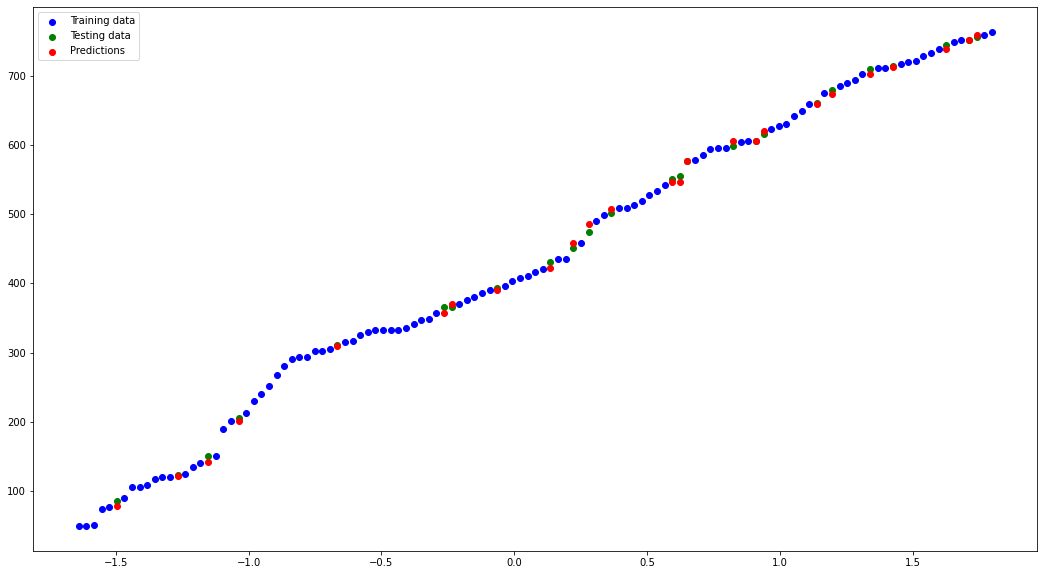

In [426]:
plot_predictions(X_train,
                 y_train,
                 X_test,
                 y_test,
                 X_test,
                 y_pred_cat,
                 True)

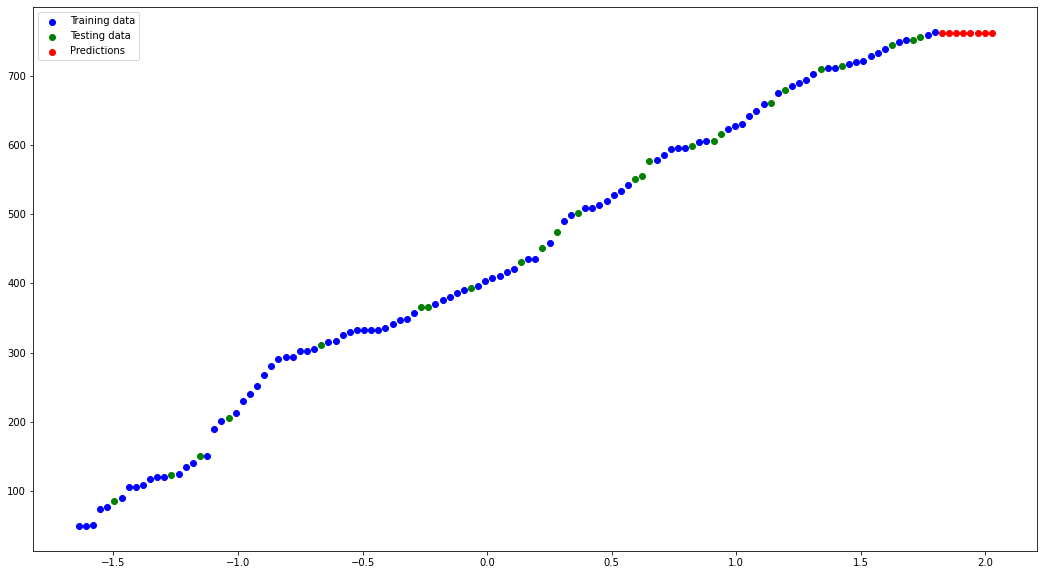

In [427]:
y_pred = cat_boost_model.predict(unseen_values)

plot_predictions(X_train,
                 y_train,
                 X_test,
                 y_test,
                 unseen_values,
                 y_pred,
                 True)

## Field Artillery Model 2

In [428]:
from xgboost import XGBRegressor

# create an xgboost regression model
xg_boost_model = XGBRegressor()
xg_boost_model.fit(X_train,y_train)

[15:15:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor()

In [429]:
y_pred_xg = xg_boost_model.predict(X_test)

int_xg_pred = []

for item in y_pred_xg:
  int_xg_pred.append(int(item))

# Get all values in order to plot them later
xg_acc = accuracy_score(y_test, int_xg_pred)
xg_f1 = f1_score(y_test,int_xg_pred, average='micro')
xg_r2 = r2_score(y_test, int_xg_pred)
xg_mae = mean_absolute_error(y_test,int_xg_pred)
xg_rmse = np.sqrt(mean_squared_error(y_test, int_xg_pred))

print("Accuracy : " , xg_acc)
print("F1",xg_f1)
print("R^2 : ", xg_r2)
print("MAE :", xg_mae)
print("RMSE:",xg_rmse)

Accuracy :  0.12
F1 0.12
R^2 :  0.9986010658896564
MAE : 5.56
RMSE: 7.475292636412303


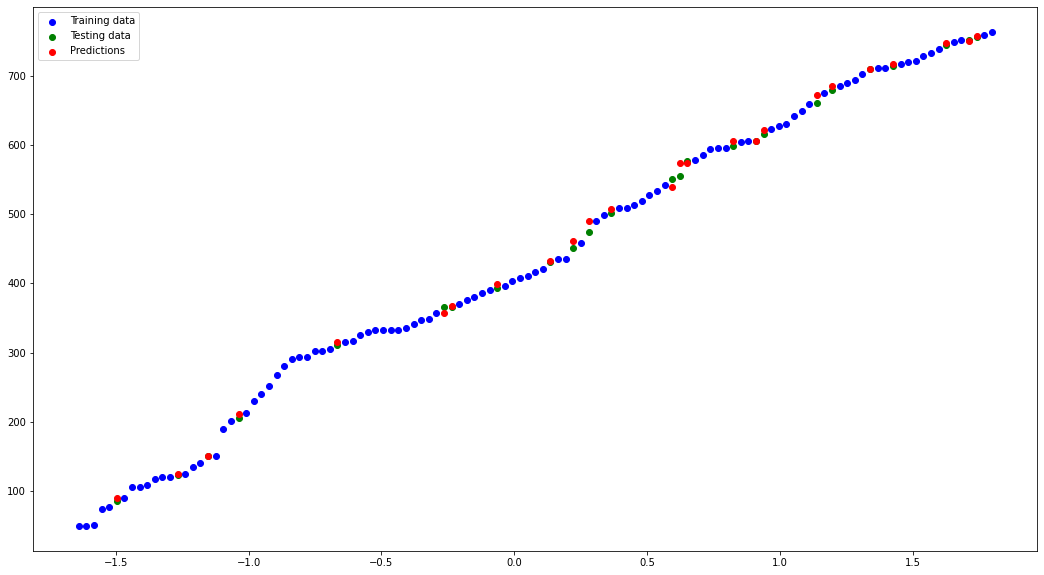

In [430]:
plot_predictions(X_train,
                 y_train,
                 X_test,
                 y_test,
                 X_test,
                 int_xg_pred,
                 True)

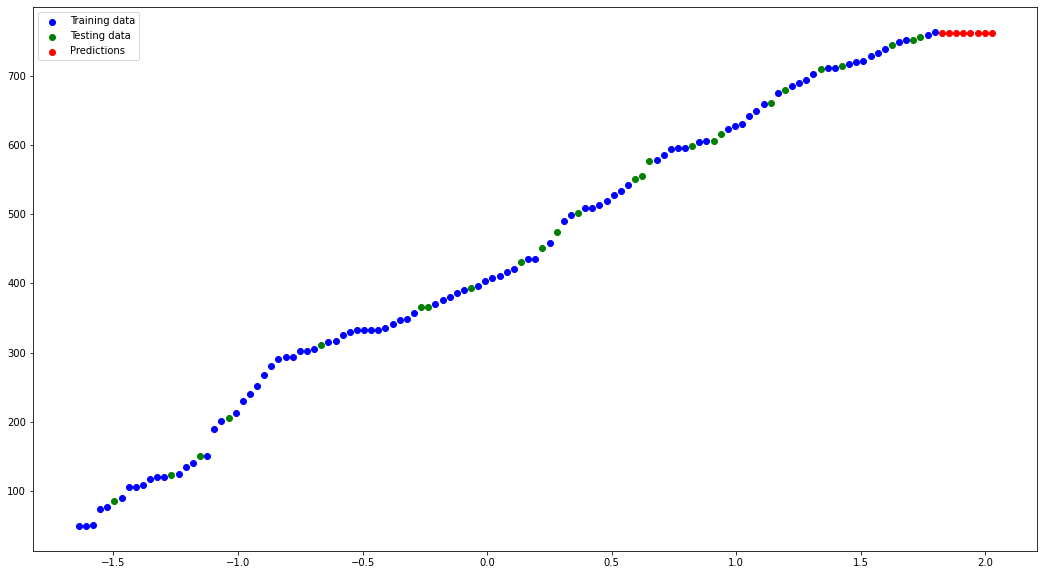

In [431]:
y_pred = xg_boost_model.predict(unseen_values)

plot_predictions(X_train,
                 y_train,
                 X_test,
                 y_test,
                 unseen_values,
                 y_pred,
                 True)

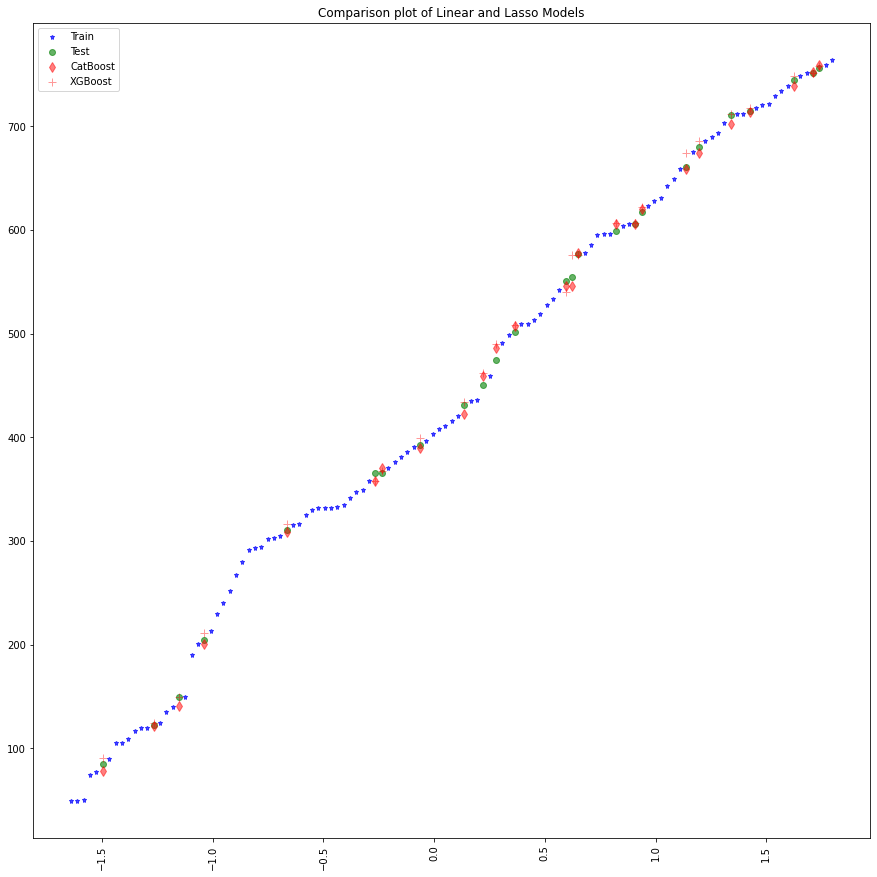

In [432]:
#plot size
plt.figure(figsize = (15, 15))

#add plot for training
plt.plot(X_train,y_train,alpha=0.7,linestyle='none',marker='*',markersize=5,color='blue',label=r'Train',zorder=7)

#addd plot for testing
plt.plot(X_test,y_test,alpha=0.6,linestyle='none',marker='o',markersize=6,color='green',label=r'Test')

#add plot for lasso model
plt.plot(X_test,y_pred_cat,alpha=0.5,linestyle='none',marker='d',markersize=7,color='red',label='CatBoost')

#add plot for linear model
plt.plot(X_test,y_pred_xg,alpha=0.4,linestyle='none',marker='+',markersize=8,color='red',label='XGBoost')

#rotate axis
plt.xticks(rotation = 90)
plt.legend()
plt.title("Comparison plot of Linear and Lasso Models")
plt.show()

In [433]:
model_results = [["Cat Boost",cat_acc,cat_f1,
                  cat_r2,cat_mae,cat_rmse],
                 ["XG Boost",xg_acc,xg_f1,
                  xg_r2,xg_mae,xg_rmse]]
model_results

[['Cat Boost', 0.12, 0.12, 0.9991187816627757, 4.96, 5.932958789676531],
 ['XG Boost', 0.12, 0.12, 0.9986010658896564, 5.56, 7.475292636412303]]

In [434]:
# Now Lets put the model results into a dataframe
model_results_df = pd.DataFrame(model_results,columns=["model","accuracy","f1",'R^2','MAE','RMSE'])
model_results_df

,model,accuracy,f1,R^2,MAE,RMSE
0,Cat Boost,0.12,0.12,0.999119,4.96,5.932959
1,XG Boost,0.12,0.12,0.998601,5.56,7.475293


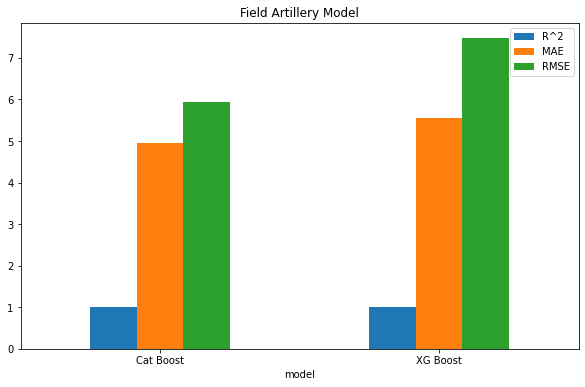

In [435]:
model_results_df.plot(x="model",y=['R^2','MAE','RMSE'],kind="bar",figsize=(10,6))
plt.title("Field Artillery Model")
plt.xticks(rotation="horizontal");

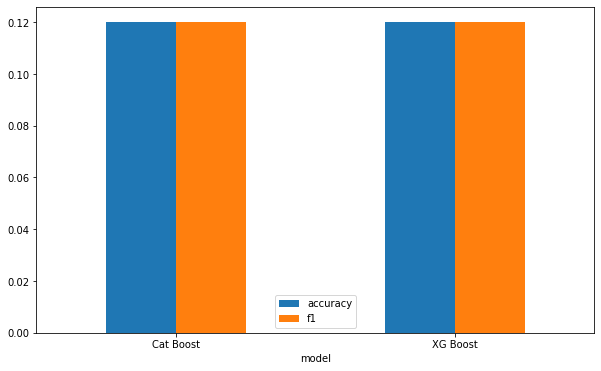

In [436]:
model_results_df.plot(x="model",y=["accuracy","f1"],kind="bar",figsize=(10,6))
plt.xticks(rotation="horizontal");